# Notebook 01 – Data Preparation (SPY Daily)

**Goal:** Build a clean, labeled daily dataset for SPY that we can reuse for all models.

This notebook will:

1. Load or download daily SPY data.
2. Clean weird rows and fix dtypes.
3. Engineer basic technical features (returns, moving averages, volatility).
4. Create the `label_up` target (1 if next day close > today, else 0).
5. Save the processed table to `data/processed/daily_merged.parquet`.
6. Do a few sanity checks and basic EDA.


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import yfinance as yf

# project paths (assuming this notebook lives in notebooks/)
ROOT = Path("..").resolve()
RAW_DIR = ROOT / "data" / "raw"
PROC_DIR = ROOT / "data" / "processed"

RAW_DIR.mkdir(parents=True, exist_ok=True)
PROC_DIR.mkdir(parents=True, exist_ok=True)

START_DATE = "2010-01-01"
END_DATE = "2025-01-01"

RAW_DIR, PROC_DIR


(WindowsPath('C:/Users/KDP only/Documents/ANN_Final_Project/spy-ann/data/raw'),
 WindowsPath('C:/Users/KDP only/Documents/ANN_Final_Project/spy-ann/data/processed'))

In [3]:
price_path = RAW_DIR / "spy_price.csv"

if price_path.exists():
    print("Loading existing raw SPY data...")
    df_raw = pd.read_csv(price_path, parse_dates=["date"])
else:
    print("Downloading SPY from Yahoo Finance...")
    df_raw = yf.download("SPY", start=START_DATE, end=END_DATE, interval="1d")
    df_raw = df_raw.rename_axis("date").reset_index()
    df_raw.to_csv(price_path, index=False)

print("\n=== RAW DATA PREVIEW ===")
display(df_raw.head())
print("\nColumns:", df_raw.columns.tolist())
print("Shape:", df_raw.shape)
print("Date range:", df_raw['date'].min(), "→", df_raw['date'].max())
print("dtypes:\n", df_raw.dtypes)


Loading existing raw SPY data...

=== RAW DATA PREVIEW ===


,date,Close,High,Low,Open,Volume
0,NaT,SPY,SPY,SPY,SPY,SPY
1,2010-01-04,85.2791976928711,85.32434499347764,83.9096740780453,84.5568121781178,118944600
2,2010-01-05,85.50495147705078,85.5425780599743,84.91801352591102,85.22653543105451,111579900
3,2010-01-06,85.56512451171875,85.77581953068422,85.35442949275328,85.42215043127418,116074400
4,2010-01-07,85.92636108398438,86.03170864374681,85.16634876768842,85.40714401014705,131091100



Columns: ['date', 'Close', 'High', 'Low', 'Open', 'Volume']
Shape: (3775, 6)
Date range: 2010-01-04 00:00:00 → 2024-12-31 00:00:00
dtypes:
 date      datetime64[ns]
Close             object
High              object
Low               object
Open              object
Volume            object
dtype: object


In [4]:
def add_technical_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 1) Parse dates and drop rows without a real date (like that NaT/SPY row)
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df[df["date"].notna()].copy()

    # 2) Sort by date, reset index
    df = df.sort_values("date").reset_index(drop=True)

    # 3) Decide which price column to use
    if "Adj Close" in df.columns:
        price_col = "Adj Close"
    elif "Close" in df.columns:
        price_col = "Close"
    else:
        raise ValueError(f"No 'Adj Close' or 'Close' column found. Columns: {df.columns}")

    # 4) Force numeric types for price-related columns
    numeric_cols = [c for c in ["Close", "Open", "High", "Low", "Adj Close", "Volume"] if c in df.columns]
    for c in numeric_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Drop any rows where price_col couldn't be parsed to a number
    df = df[df[price_col].notna()].copy()

    # 5) Basic returns
    df["ret_1d"] = df[price_col].pct_change()
    df["log_ret_1d"] = np.log(df[price_col] / df[price_col].shift(1))

    # 6) Moving averages
    df["ma_close_5"] = df[price_col].rolling(5).mean()
    df["ma_close_20"] = df[price_col].rolling(20).mean()

    # 7) Rolling volatility
    df["vol_5"] = df["ret_1d"].rolling(5).std()
    df["vol_20"] = df["ret_1d"].rolling(20).std()

    # 8) Target: next-day up/down
    df["future_price"] = df[price_col].shift(-1)
    df["future_ret_1d"] = (df["future_price"] / df[price_col]) - 1.0
    df["label_up"] = (df["future_ret_1d"] > 0).astype("int64")

    # 9) Drop NaNs and last row (no future)
    df = df.dropna().reset_index(drop=True)

    return df


In [5]:
df = add_technical_features(df_raw)

print("=== PROCESSED DATA PREVIEW ===")
display(df.head())
print("\nColumns:", df.columns.tolist())
print("Shape:", df.shape)
print(df.dtypes)


=== PROCESSED DATA PREVIEW ===


,date,Close,High,Low,Open,Volume,ret_1d,log_ret_1d,ma_close_5,ma_close_20,vol_5,vol_20,future_price,future_ret_1d,label_up
0,2010-02-02,83.059364,83.217386,81.930636,82.216584,216327900,0.012104,0.012031,82.055548,84.347997,0.012653,0.010585,82.645493,-0.004983,0
1,2010-02-03,82.645493,83.134609,82.404697,82.683113,172730700,-0.004983,-0.004995,82.055548,84.205024,0.012873,0.010574,80.094604,-0.030865,0
2,2010-02-04,80.094604,82.043540,80.079552,82.005919,356715700,-0.030865,-0.031352,81.734995,83.931498,0.018783,0.012403,80.260124,0.002067,1
3,2010-02-05,80.260124,80.425666,78.694953,80.184871,493585800,0.002067,0.002064,81.625131,83.648186,0.018457,0.012344,79.680710,-0.007219,0
4,2010-02-08,79.680710,80.764291,79.620510,80.320322,224166900,-0.007219,-0.007245,81.148059,83.321606,0.015917,0.012270,80.681526,0.012560,1



Columns: ['date', 'Close', 'High', 'Low', 'Open', 'Volume', 'ret_1d', 'log_ret_1d', 'ma_close_5', 'ma_close_20', 'vol_5', 'vol_20', 'future_price', 'future_ret_1d', 'label_up']
Shape: (3753, 15)
date             datetime64[ns]
Close                   float64
High                    float64
Low                     float64
Open                    float64
Volume                    int64
ret_1d                  float64
log_ret_1d              float64
ma_close_5              float64
ma_close_20             float64
vol_5                   float64
vol_20                  float64
future_price            float64
future_ret_1d           float64
label_up                  int64
dtype: object


Date range: 2010-02-02 00:00:00 → 2024-12-30 00:00:00

Label distribution (counts):
label_up
1    2074
0    1679
Name: count, dtype: int64

Label distribution (proportion):
label_up
1    0.552625
0    0.447375
Name: proportion, dtype: float64


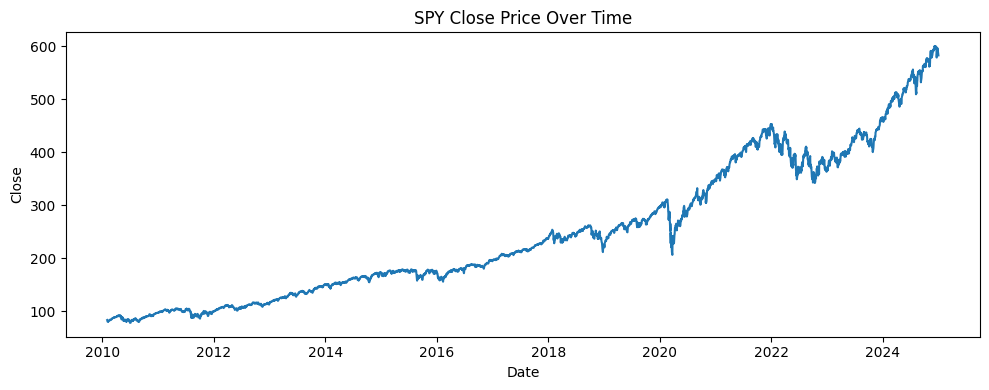

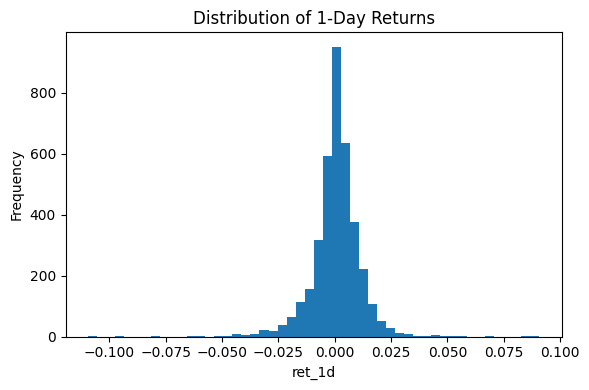

In [7]:
import matplotlib.pyplot as plt

print("Date range:", df["date"].min(), "→", df["date"].max())
print("\nLabel distribution (counts):")
print(df["label_up"].value_counts())
print("\nLabel distribution (proportion):")
print(df["label_up"].value_counts(normalize=True))

# Quick plot of close price over time
plt.figure(figsize=(10, 4))
plt.plot(df["date"], df["Close"])
plt.title("SPY Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close")
plt.tight_layout()
plt.show()

# Histogram of 1-day returns
plt.figure(figsize=(6, 4))
plt.hist(df["ret_1d"], bins=50)
plt.title("Distribution of 1-Day Returns")
plt.xlabel("ret_1d")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [8]:
out_path = PROC_DIR / "daily_merged.parquet"
df.to_parquet(out_path, index=False)
out_path, df.shape


(WindowsPath('C:/Users/KDP only/Documents/ANN_Final_Project/spy-ann/data/processed/daily_merged.parquet'),
 (3753, 15))

## Notes for Report

- **Raw data source:** Yahoo Finance (`SPY`, daily, 2010–2024).
- We observed a spurious first row where the header (`SPY`) appeared as data, with `date = NaT`. This was removed by dropping rows with invalid dates.
- Price columns were initially loaded as strings; we coerced them to numeric and dropped any resulting NaNs.
- We used **Close** (or **Adj Close**, if available) as the main price column for:
  - 1-day returns (`ret_1d`)
  - log returns (`log_ret_1d`)
  - moving averages (5 and 20 days)
  - rolling volatility (5 and 20 days)
- The target label `label_up` is defined as:
  - `1` if the next day’s close is higher than today’s
  - `0` otherwise
- After dropping initial warm-up rows (for rolling windows) and the final row (no future price), we obtained **N = <automatically shown in df.shape>** samples.
- The class distribution is slightly imbalanced (~55% up days, 45% down days), which we will compare to our model accuracies later.
